In [1]:
# imports cell
import numpy as np
import pandas as pd
import _pickle as pk
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings

# to create a tensor on the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')

In [2]:
filename = "D:\Projects\Python_Projects\ML\ModulationClassification_Pytorch\RML2016.10b\RML2016.10b.dat"
open_file = open(filename, 'rb')
data = pk.load(open_file, encoding='latin1')

In [3]:
signals_df = pd.DataFrame(list(data.items()), columns=['Key', 'Data'])
signals_df['Label'], signals_df['SNR'] = signals_df.Key.str
signals_df

,Key,Data,Label,SNR
0,"(QPSK, 2)","[[[-0.0075228056, -0.0056156227, -0.004400276,...",QPSK,2
1,"(PAM4, 8)","[[[0.00048308217, -0.00052503555, 0.0005379811...",PAM4,8
2,"(AM-DSB, -4)","[[[0.001359591, 0.0030759352, -0.0070046755, -...",AM-DSB,-4
3,"(GFSK, 6)","[[[0.0024218021, 0.001641912, 0.00010403033, -...",GFSK,6
4,"(QAM64, 8)","[[[-0.0047246083, -0.004052764, -0.002794009, ...",QAM64,8
...,...,...,...,...
195,"(QPSK, -4)","[[[-0.003440612, -0.0059135226, 0.0031228333, ...",QPSK,-4
196,"(8PSK, -2)","[[[0.008129765, 0.01309299, -0.002217424, 0.00...",8PSK,-2
197,"(GFSK, -12)","[[[0.003865175, -0.0034481273, 0.0036327532, -...",GFSK,-12
198,"(8PSK, 6)","[[[0.006229489, -0.0031945696, 0.005326481, -0...",8PSK,6


In [4]:
SNR_list = np.sort(signals_df.SNR.unique())
Classes = signals_df.Label.unique()

SNR_list, Classes

(array([-20, -18, -16, -14, -12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,
          6,   8,  10,  12,  14,  16,  18], dtype=int64),
 array(['QPSK', 'PAM4', 'AM-DSB', 'GFSK', 'QAM64', 'QAM16', '8PSK', 'WBFM',
        'BPSK', 'CPFSK'], dtype=object))

In [5]:
snr_0 = signals_df[signals_df['SNR'] == SNR_list[10]]
snr_0

,Key,Data,Label,SNR
22,"(CPFSK, 0)","[[[0.008498599, 0.0032935098, 0.009257533, -0....",CPFSK,0
44,"(WBFM, 0)","[[[-0.0001971325, 0.005053609, -0.0011216417, ...",WBFM,0
55,"(BPSK, 0)","[[[0.0024843407, 0.0058399215, 0.00029465533, ...",BPSK,0
73,"(8PSK, 0)","[[[0.004954453, -0.0025108524, -0.006107292, 0...",8PSK,0
77,"(GFSK, 0)","[[[0.0070821354, 0.0045982446, 0.0061556743, -...",GFSK,0
80,"(QAM16, 0)","[[[0.0017232103, -0.0062997793, -0.019598406, ...",QAM16,0
106,"(PAM4, 0)","[[[-0.00017230351, 0.0024808664, -0.0003051981...",PAM4,0
110,"(QAM64, 0)","[[[0.00039049715, -0.0014383754, -0.0007713570...",QAM64,0
120,"(QPSK, 0)","[[[-0.0027371016, 0.0024517025, 0.0027217618, ...",QPSK,0
146,"(AM-DSB, 0)","[[[0.003235979, 0.00036907254, 0.0030784816, -...",AM-DSB,0


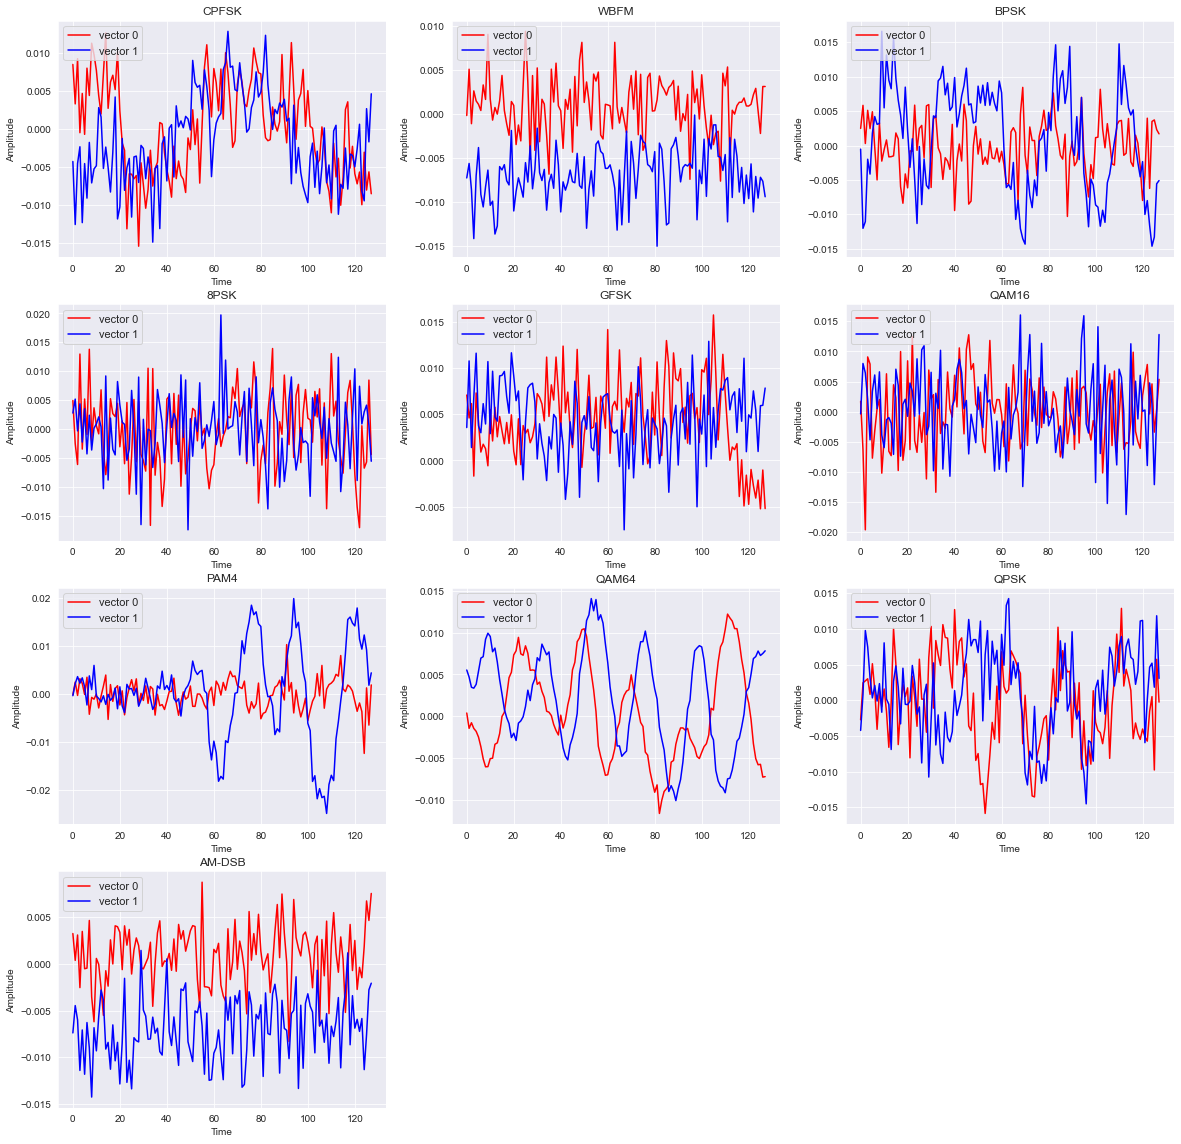

In [6]:
plt.figure(figsize=(20, 20))

for i in range(len(snr_0)):
    plt.subplot(4, 3, i + 1)
    plt.plot(snr_0['Data'].iloc[i][0][0], color='red', label='vector 0')
    plt.plot(snr_0['Data'].iloc[i][0][1], color='blue', label='vector 1')
    plt.legend(loc='upper left', fontsize=11)
    plt.title(snr_0['Label'].iloc[i])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')


In [7]:
x = []
y = []
s = []

for i in range(len(signals_df)):
    data_array = signals_df['Data'].iloc[i]
    label = signals_df['Label'].iloc[i]
    snr = signals_df['SNR'].iloc[i]
    for j in range(data_array.shape[0]):
        x.append(data_array[j])
        y.append(label)
        s.append(snr)

s = np.array(s)
#x = np.array(x)
le = LabelEncoder()
y = le.fit_transform(y)
y = np.array(y)


In [8]:
features = 'raw'
num_inputs = 2

if features == 'raw':
   x_data = np.array(x, dtype=np.float64)

elif features == 'der':
    #der_X = np.apply_along_axis(lambda column: np.gradient(column), 2, x)
    #np.save('./der_X.npy',der_X)
    x_data = np.load('./der_X.npy')

elif features == 'int':
    #int_X = np.apply_along_axis(lambda column: np.hstack((0, column)), 2,np.apply_along_axis(lambda column: integrate.cumtrapz(column, dx=1, axis=-1), 2, x))
    #np.save('./int_X.npy',int_X)
    x_data = np.load('./int_X.npy')

elif features == 'der_plus_X':
    der_X = np.load('./der_X.npy')
    x = np.array(x)
    x_data = np.concatenate((der_X, x), axis=1)
    num_inputs = 4

elif features == 'int_plus_X':
    int_X = np.load('./int_X.npy')
    x = np.array(x)
    x_data = np.concatenate((int_X, x), axis=1)
    num_inputs = 4

elif features == 'der_plus_int':
    der_X = np.load('./der_X.npy')
    int_X = np.load('./int_X.npy')
    x_data = np.concatenate((der_X, int_X), axis=1)
    num_inputs = 4

elif features == 'combo':
    der_X = np.load('./der_X.npy')
    int_X = np.load('./int_X.npy')
    x = np.array(x)
    x_data = np.concatenate((der_X, int_X, x), axis=1)
    num_inputs = 6


In [9]:
x_train_val, x_test, y_train_val, y_test, snr_train_val, snr_test = train_test_split(x_data, y, s, test_size=0.3, stratify=y,
                                                                                     random_state=42)

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.05, stratify=y_train_val,
                                                  random_state=42)

In [11]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((798000, 2, 128),
 (798000,),
 (42000, 2, 128),
 (42000,),
 (360000, 2, 128),
 (360000,))

In [12]:
class MyDataset(Dataset):
    def __init__(self, array, labels):
        self.array = array
        self.labels = labels

    def __getitem__(self, index):
        d = self.array[index].T
        return torch.tensor(d, dtype=torch.float64, device=device), torch.tensor(self.labels[index],device=device)  #,device=device

    def __len__(self):
        return len(self.array)

In [13]:
trainDataset = MyDataset(x_train, y_train)

train_dataloader = DataLoader(trainDataset, batch_size=512, shuffle=True)  # ,num_workers=1,pin_memory=True

In [14]:
valDataset = MyDataset(x_val, y_val)

val_dataloader = DataLoader(valDataset, batch_size=512, shuffle=True)

In [15]:
testDataset = MyDataset(x_test, y_test)

test_dataloader = DataLoader(testDataset, batch_size=512, shuffle=True)

In [16]:
class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #input_size – The number of expected features in the input x
        #hidden_size – The number of features in the hidden state h
        #num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs
        #batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature).
        # Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
        #nonlinearity='relu',dropout=0.5
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True).double()

        for name,parm in self.rnn.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_normal_(parm)

        #self.h0 = self.init_hidden()

        self.fc1 = nn.Linear(hidden_size, 256).double()
        torch.nn.init.xavier_normal_(self.fc1.weight)

        self.fc2 = nn.Linear(256, 10).double()
        torch.nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, data):
        #num layer ,batch ,hidden_size
        h0 = torch.zeros(self.num_layers, data.size(0), self.hidden_size,dtype=torch.float64).to(device)
        #torch.nn.init.xavier_normal_(h0)

        data, _ = self.rnn(data, h0.detach())

        # data: batch , seq , hidden_size = 128
        # data : N , 128
        data = self.fc1(data[:, -1, :])
        data = F.relu(data)

        data = self.fc2(data)

        return data

    def init_hidden(self):
        h0 = torch.zeros(self.num_layers, 512, self.hidden_size,dtype=torch.float64)
        torch.nn.init.xavier_normal_(h0)
        h0= h0.cuda()

        return Variable(h0)


In [17]:
def train_model(model, dataloader, optimizer):
    model.train()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0

    for (data, label) in dataloader:
        # forward pass
        output = model(data.clone())

        _, predicted = torch.max(output.data, 1)

        # compute loss
        loss_ = loss(output, label)
        total_loss += loss_.item()

        # reset gradients (it will accumulate gradients otherwise)
        optimizer.zero_grad()

        # backward propagation dl/dw -> gradients
        loss_.backward()#retain_graph=True

        # update weights
        optimizer.step()

        pred += predicted.tolist()
        labels += label.tolist()

    return accuracy_score(labels, pred) * 100, total_loss / len(dataloader)

In [18]:
def test_model(model, dataloader):
    model.eval()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0

    with torch.no_grad():
        for (data, label) in dataloader:
            output = model(data)

            _, predicted = torch.max(output.data, 1)

            # compute loss
            loss_ = loss(output, label)
            total_loss += loss_.item()

            pred += predicted.tolist()
            labels += label.tolist()

    return labels, pred, accuracy_score(labels, pred) * 100, total_loss / len(dataloader)

In [19]:
model_path_raw = "./rnn_model.pth"

model = RNN_Model(num_inputs, 128, 1).to(device)

torch.backends.cudnn.benchmark = True

#model.load_state_dict(torch.load(model_path_raw))

print('Number of Parameters : ',sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of Parameters :  52490


In [20]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, threshold=0.0001)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000001, weight_decay=0.00001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)#,momentum=0.9, weight_decay=0.00001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, threshold=0.001)


In [21]:
train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

In [22]:
epoch = 30
# 798000 sample and batch size = 512 then 798000/512 ~= 1560 iteration per epoch (batch)

# Train and validate model

for e in range(epoch):
    train_accuracy, train_loss = train_model(model, train_dataloader, optimizer)

    val_labels, val_pred, val_accuracy, val_loss = test_model(model, val_dataloader)

    # Decay Learning Rate
    scheduler.step(val_loss)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)

    print('epoch: ', e + 1, '\nTraining loss: ', train_loss, 'Training Accuracy: ', train_accuracy, '%', '  Val loss: ',
          val_loss, 'Val Accuracy: ', val_accuracy, '%')
    print('learning rate :', optimizer.state_dict()['param_groups'][0]['lr'], '\n')

    # if e % 25 == 0 and e > 0 :
    #     torch.save(model.state_dict(), model_path_raw+str(e))

epoch:  1 
Training loss:  2.3029323692345285 Training Accuracy:  10.478070175438596 %   Val loss:  2.29967982731256 Val Accuracy:  13.733333333333334 %
learning rate : 1e-05 

epoch:  2 
Training loss:  2.2178263743860747 Training Accuracy:  14.472055137844611 %   Val loss:  2.1604851484020315 Val Accuracy:  16.135714285714286 %
learning rate : 1e-05 

epoch:  3 
Training loss:  2.1417477837571166 Training Accuracy:  16.74473684210526 %   Val loss:  2.1232152092771677 Val Accuracy:  16.80238095238095 %
learning rate : 1e-05 

epoch:  4 
Training loss:  2.120987226841754 Training Accuracy:  16.984461152882204 %   Val loss:  2.1221191421755865 Val Accuracy:  16.514285714285716 %
learning rate : 1e-05 

epoch:  5 
Training loss:  2.1130634545942972 Training Accuracy:  17.130576441102757 %   Val loss:  2.1114059657481903 Val Accuracy:  17.316666666666666 %
learning rate : 1e-05 

epoch:  6 
Training loss:  2.1063699056306517 Training Accuracy:  17.487092731829573 %   Val loss:  2.09942372

Test loss:  1.775652367316586 Test Accuracy:  28.996111111111112 %


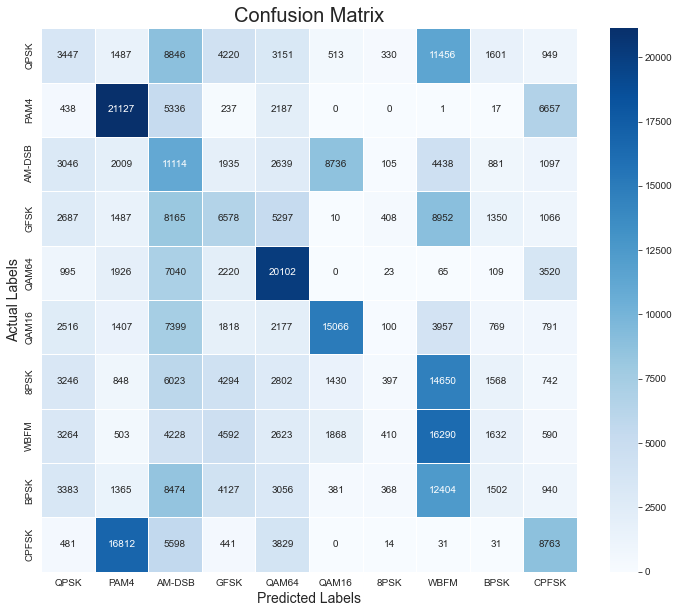

In [23]:
# test model

test_labels, test_pred, test_accuracy, test_loss = test_model(model, test_dataloader)
print('Test loss: ', test_loss, 'Test Accuracy: ', test_accuracy, '%')

cm = confusion_matrix(test_labels, test_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in Classes], columns=[i for i in Classes])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

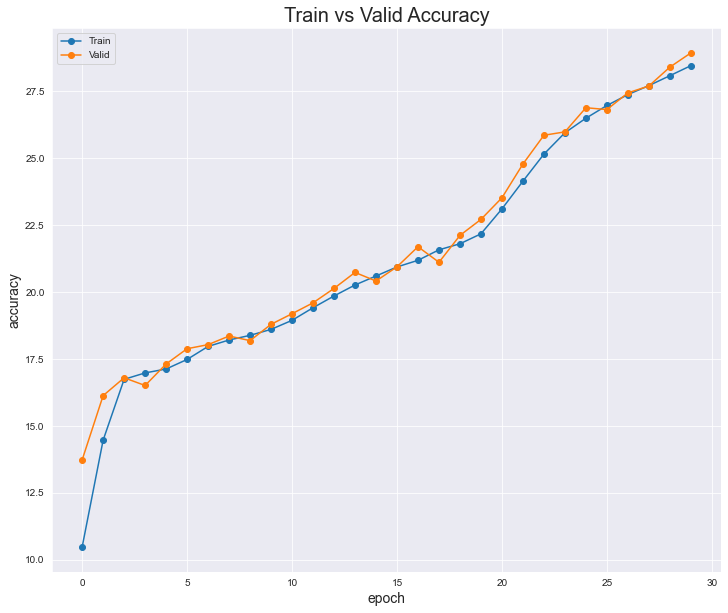

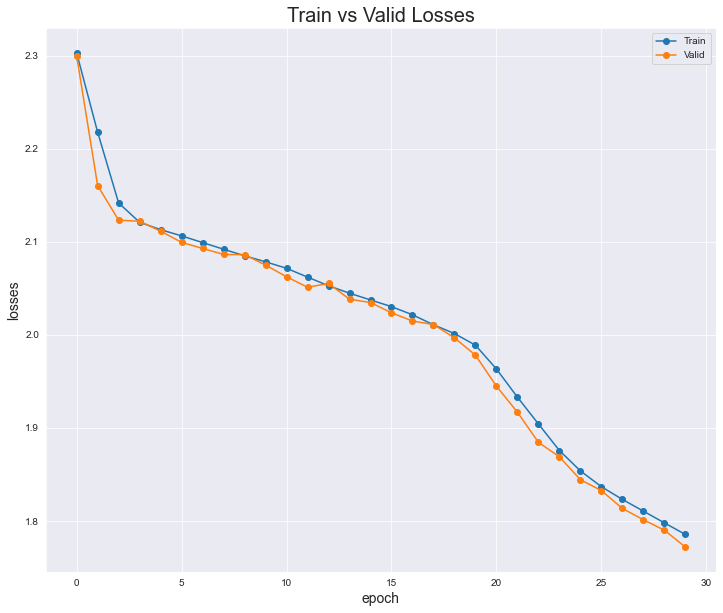

In [24]:
plt.figure(figsize=(12, 10))
plt.plot(train_acc_list, '-o')
plt.plot(val_acc_list, '-o')
plt.xlabel('epoch', size=14)
plt.ylabel('accuracy', size=14)
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Accuracy', size=20)

plt.show()

plt.figure(figsize=(12, 10))
plt.plot(train_loss_list, '-o')
plt.plot(val_loss_list, '-o')
plt.xlabel('epoch', size=14)
plt.ylabel('losses', size=14)
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Losses', size=20)

plt.show()

In [28]:
torch.save(model.state_dict(), model_path_raw)

SNR  -20  Accuracy =  10.514652927815634


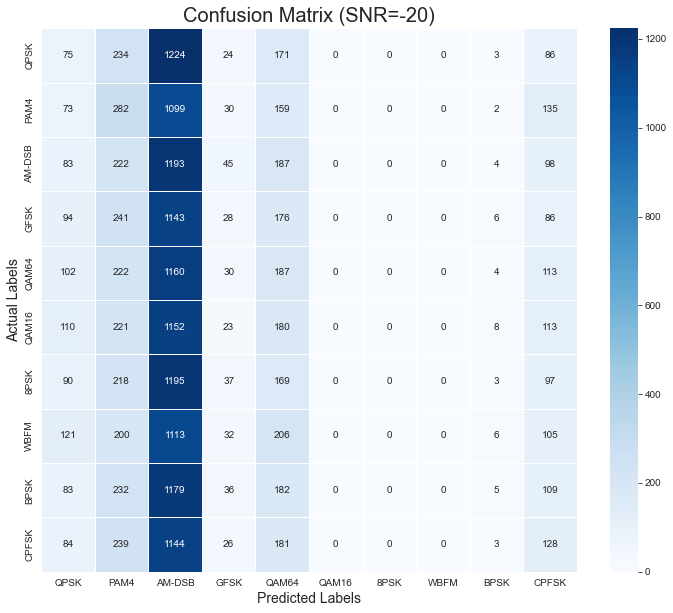

SNR  -18  Accuracy =  10.716076901643913


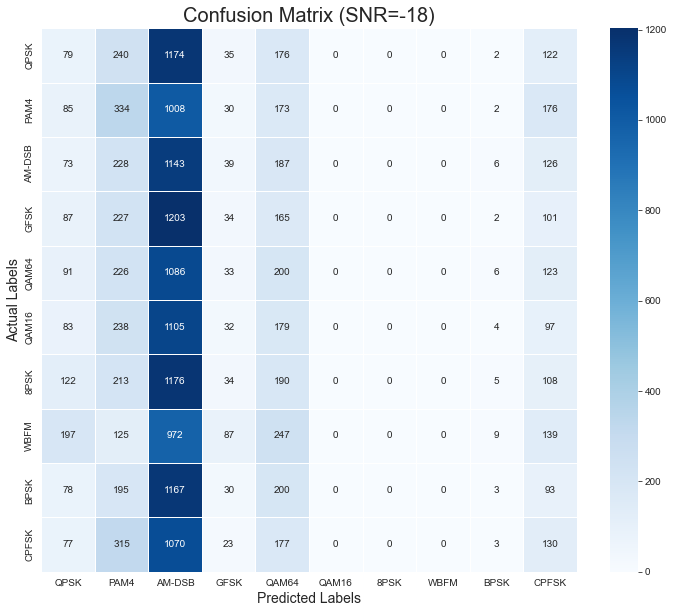

SNR  -16  Accuracy =  11.29049972542559


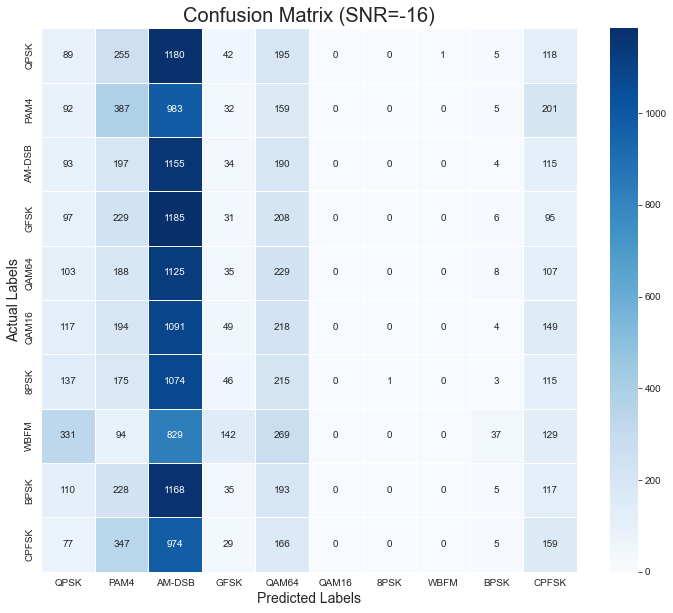

SNR  -14  Accuracy =  12.575514049769994


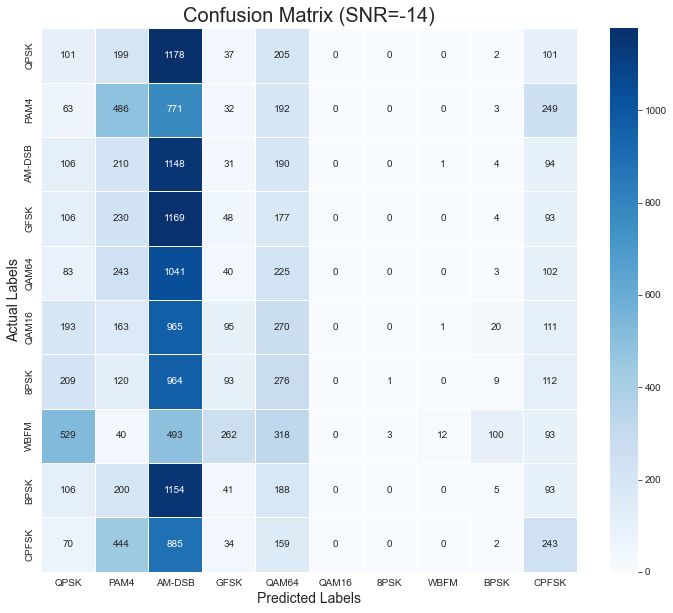

SNR  -12  Accuracy =  14.450963028558778


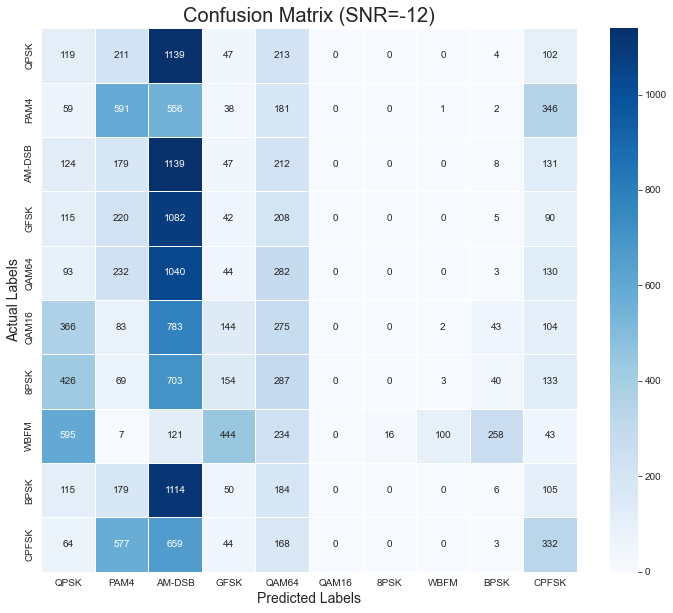

SNR  -10  Accuracy =  19.807596062948342


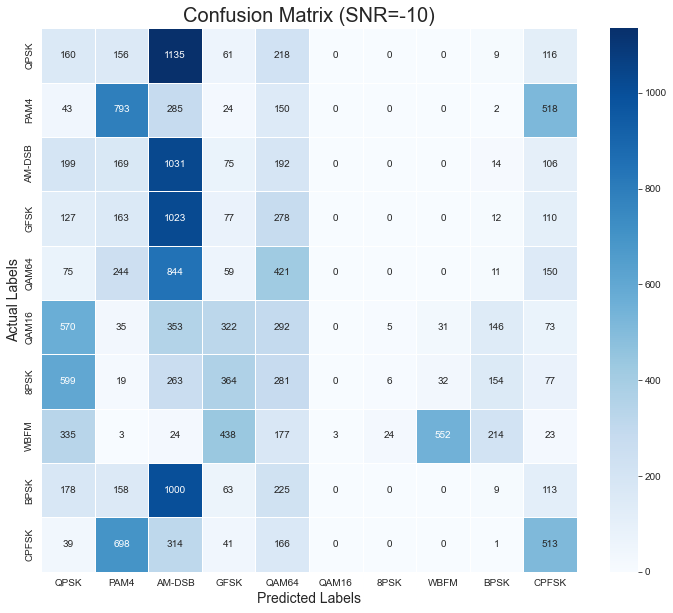

SNR  -8  Accuracy =  24.039051603905158


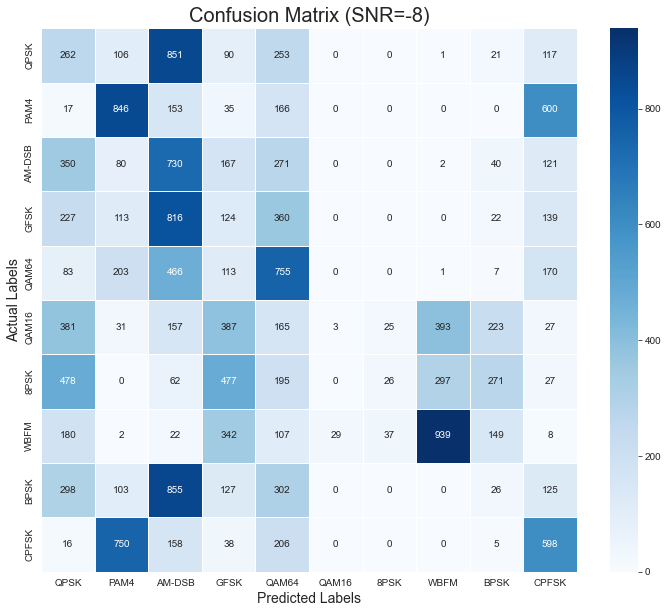

SNR  -6  Accuracy =  28.9157300229268


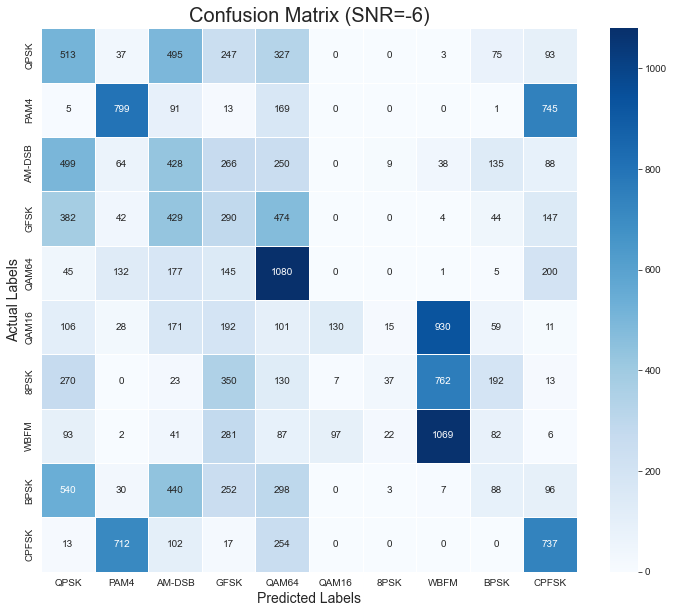

SNR  -4  Accuracy =  36.899164776812874


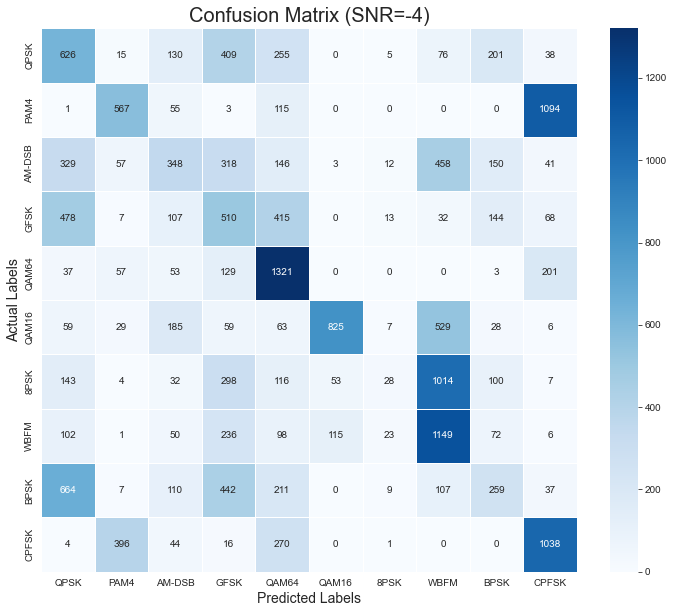

SNR  -2  Accuracy =  37.906419050805866


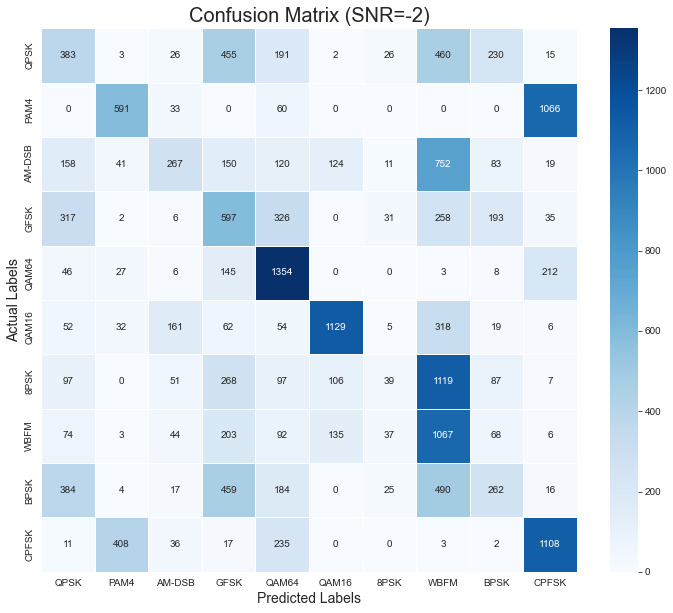

SNR  0  Accuracy =  38.26516299164002


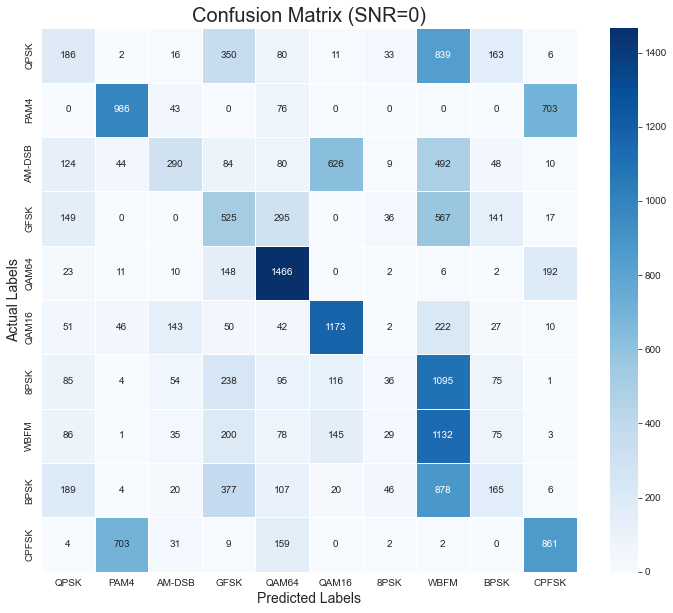

SNR  2  Accuracy =  37.916689777580565


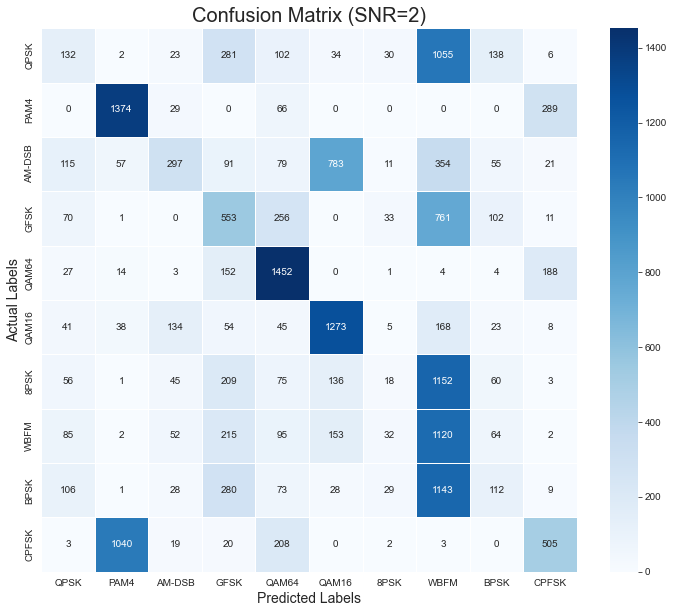

SNR  4  Accuracy =  37.973199329983245


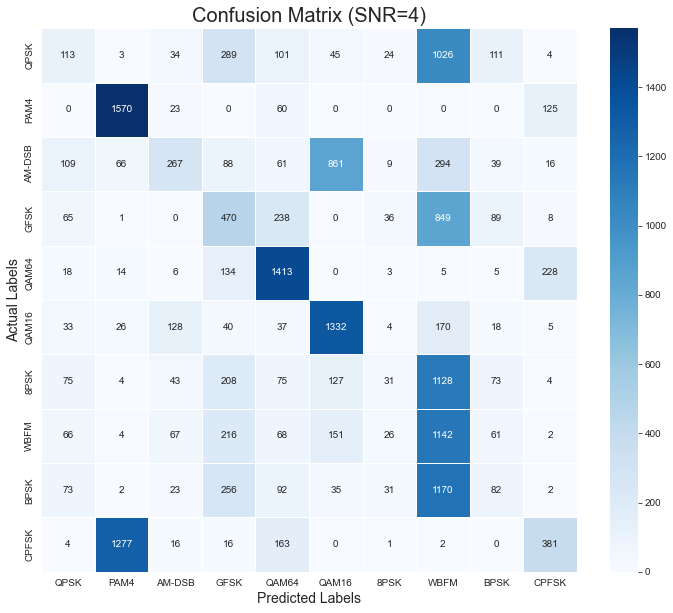

SNR  6  Accuracy =  37.13647781188948


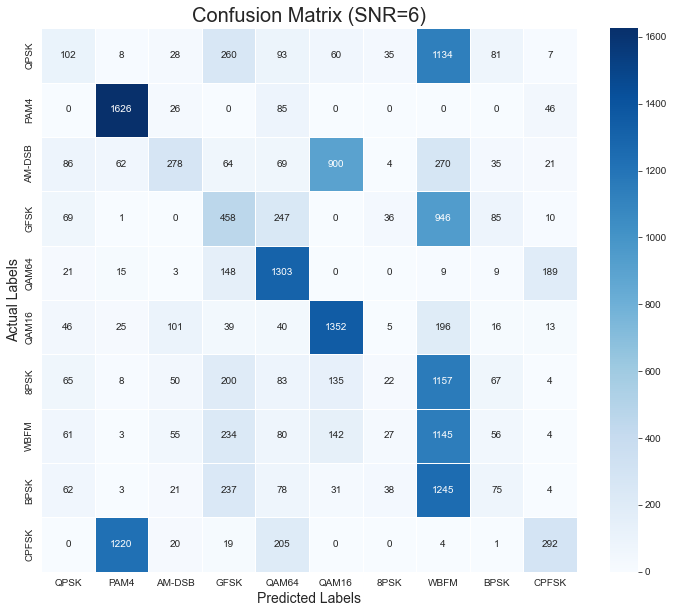

SNR  8  Accuracy =  37.06425059388984


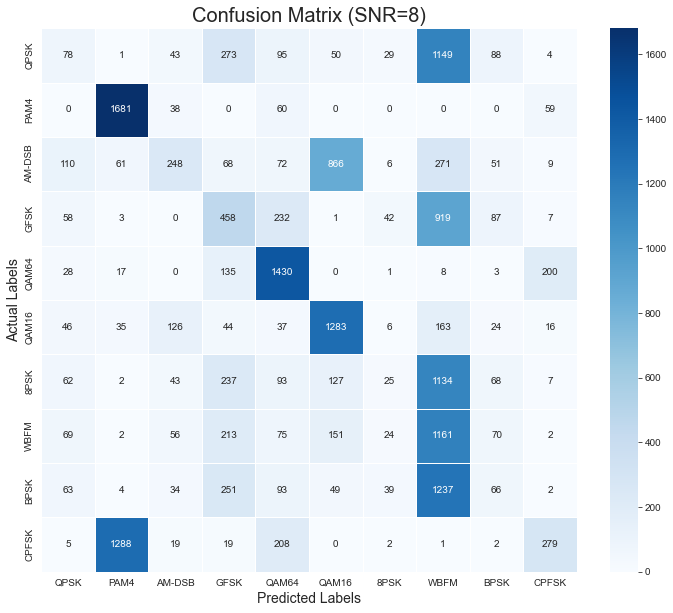

SNR  10  Accuracy =  36.902560654451726


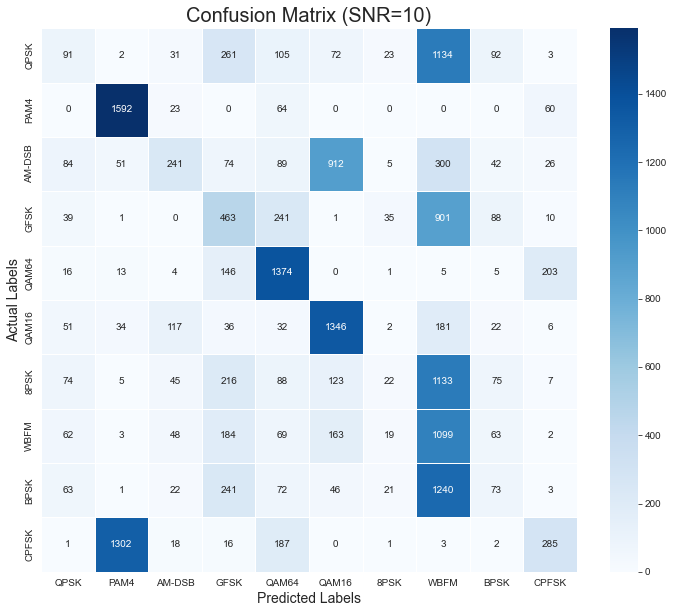

SNR  12  Accuracy =  36.52871386397816


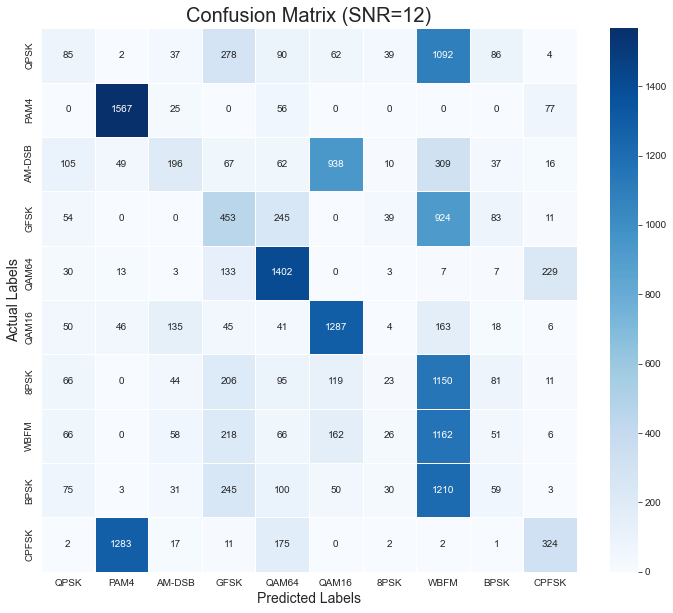

SNR  14  Accuracy =  37.266020700286276


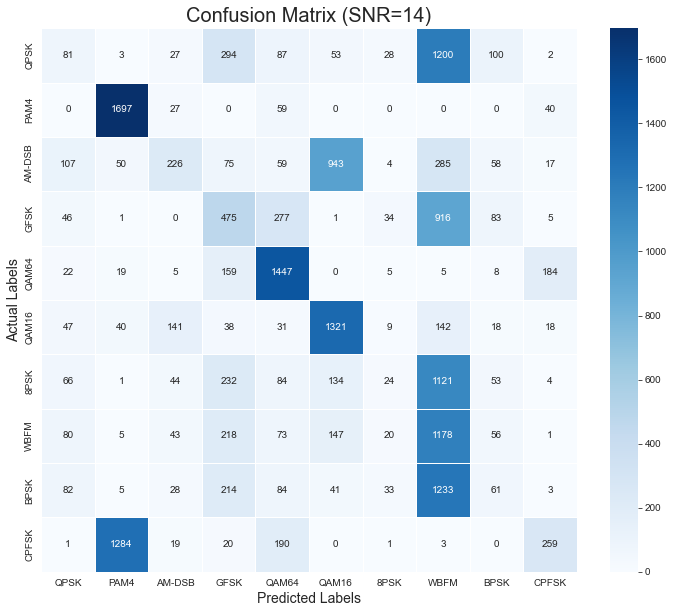

SNR  16  Accuracy =  37.34240212342402


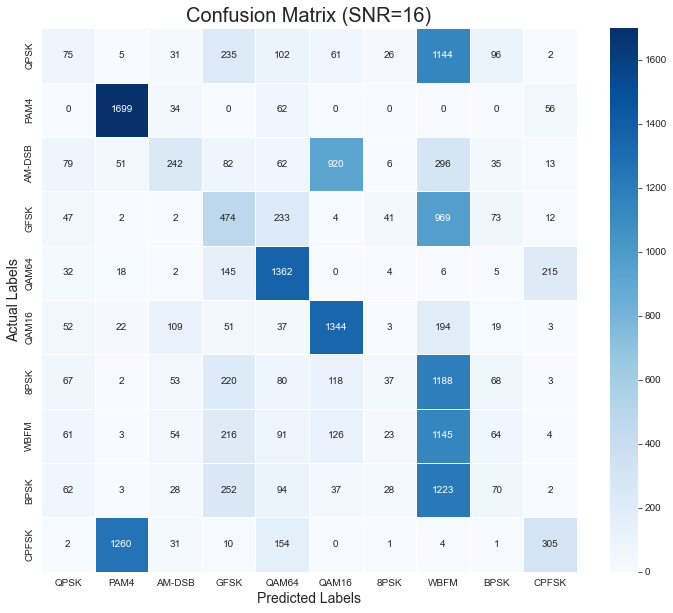

SNR  18  Accuracy =  36.74124944616748


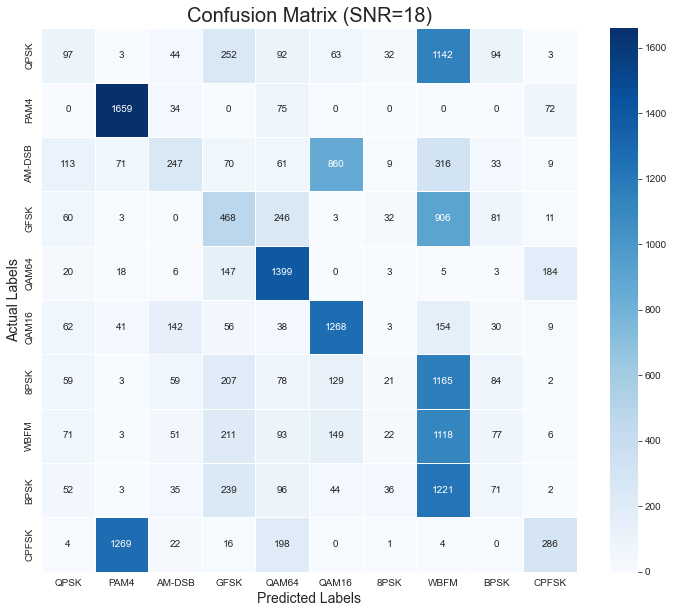

In [26]:
Acc_list = []
for snr in SNR_list:

    indices = np.where(snr_test == snr)
    x_test_i = x_test[indices]
    y_test_i = y_test[indices]

    testDataset_i = MyDataset(x_test_i, y_test_i)

    test_dataloader_i = DataLoader(testDataset_i, batch_size=512, shuffle=True)

    test_labels, test_pred, test_accuracy, test_loss = test_model(model, test_dataloader_i)

    print('SNR ',snr,' Accuracy = ',test_accuracy)
    Acc_list.append(test_accuracy)

    cm = confusion_matrix(test_labels, test_pred)
    plt.figure(figsize=(12, 10))
    cm = pd.DataFrame(cm, index=[i for i in Classes], columns=[i for i in Classes])
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix (SNR=%d)' % (snr), size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

Text(0.5, 1.0, 'Classification Accuracy')

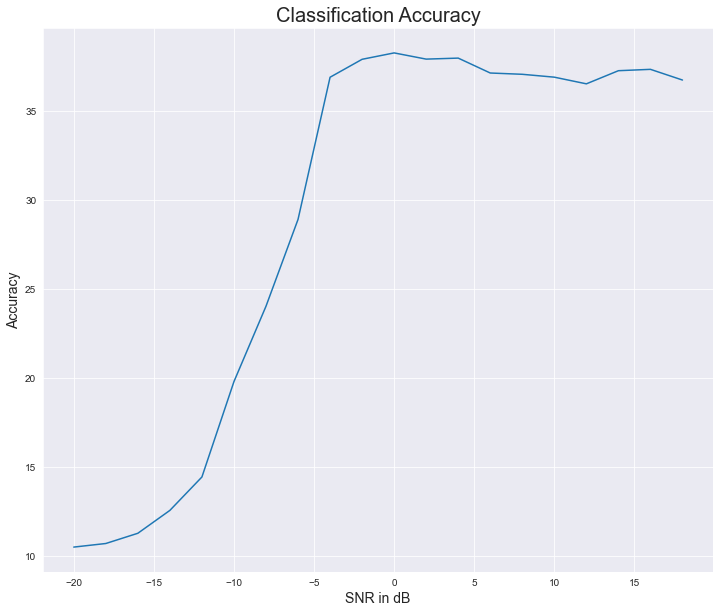

In [27]:
plt.figure(figsize=(12, 10))
plt.plot(SNR_list,Acc_list)
plt.xlabel("SNR in dB", size=14)
plt.ylabel("Accuracy", size=14)
plt.title("Classification Accuracy", size=20)